In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import sys 
import statsmodels as sm
import statsmodels.api as smapi
import statsmodels.regression.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from fbprophet import Prophet
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report
logging.getLogger().setLevel(logging.ERROR)
sys.path.append(os.path.abspath("../../"))
import Utilities as utils
import Constants as c
from scipy.special import inv_boxcox
from scipy.stats import boxcox
%matplotlib inline

In [2]:
project_name = "linux"
directoryPath = "../../exports"
task = "BUG"
bugs = "{directoryPath}/{project_name}/{project_name}_dataset_{task}.csv".format(directoryPath=directoryPath, project_name=project_name, task=task)

cc_columns = [c.VERSION, c.DATE, c.NT_CC, c.NO_CC, c.MODULE_CC, c.LINE_CC, c.T_MODULE, c.T_LINE, c.T_CC]
df = pd.read_csv(bugs, usecols = cc_columns)
df = df.dropna(subset=[c.T_MODULE])
df = df.dropna(subset=[c.DATE])
df[c.DATE] = pd.to_datetime(df[c.DATE])
df = df.set_index(c.DATE)
df.index = df.index.strftime('%Y-%m-%d') 
if df.isna().values.any():
    df.fillna(0, inplace=True)
# df = utils.remove_outlier(df, c.LINE_CC)
# df = utils.remove_outlier(df, c.MODULE_CC)
# df = df[df.Version.str.contains(r"^[v]{0,1}\d{1,2}\.\d{1,2}\.\d{1,2}[\.\d{1,2}]{0,2}$", regex=True, na=False)]
# df.head()

In [7]:
def forecastVariable(variable, dataFrame, months):
    data = {
        c.DATE: dataFrame.index,
        c.NT_CC: dataFrame[c.NT_CC]
    }
    NT = pd.DataFrame(data) 

    NT.columns = ['ds','y']
    NT['y_orig'] = NT['y']
    NT['y'], lam = boxcox(NT['y'])

    m_NT = Prophet(interval_width=0.90)
    m_NT.fit(NT)
    future_NT = m_NT.make_future_dataframe(periods=months, freq='m')
    forecast_NT = m_NT.predict(future_NT)

    m_NT.plot(forecast_NT)

    forecast_NT_inv = pd.DataFrame()
    forecast_NT_inv['ds'] = forecast_NT['ds']
    forecast_NT_inv[['yhat','yhat_upper','yhat_lower']] = forecast_NT[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

    m_NT.history['y_t'] = m_NT.history['y']
    m_NT.history['y'] = m_NT.history['y_orig']

    NT['y_t'] = NT['y']
    NT['y'] = NT['y_orig']

    m_NT.plot(forecast_NT_inv)

    return forecast_NT_inv

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
547,2019-06-30,18.889222,2.039474,91.977418
548,2019-07-31,14.845296,1.233384,81.072412
549,2019-08-31,9.879703,0.572565,58.488275
550,2019-09-30,11.711682,0.798363,66.366087
551,2019-10-31,11.545722,0.949997,61.762487
552,2019-11-30,11.608223,0.693101,66.390359
553,2019-12-31,6.121816,0.239868,47.756491
554,2020-01-31,11.606821,0.752780,72.078924
555,2020-02-29,18.727869,1.710518,90.414857
556,2020-03-31,12.076178,0.880851,63.832837


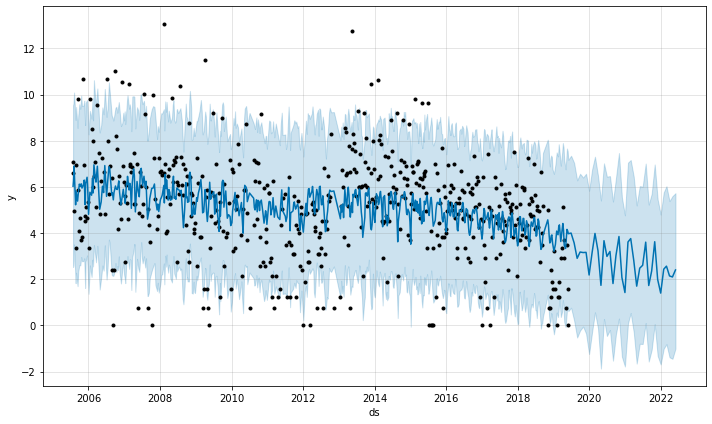

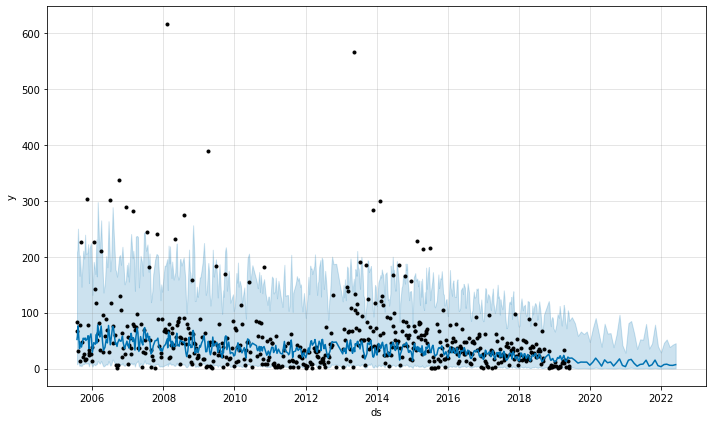

In [8]:
forecast_NT = forecastVariable(c.NT_CC, df, 36)
forecast_NT[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(36)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
578,2022-01-31,7.267111,0.380353,47.320982
579,2022-02-28,7.941081,0.476290,58.197570
580,2022-03-31,5.949607,0.289370,42.514613
581,2022-04-30,5.764543,0.242238,40.285706
582,2022-05-31,7.110356,0.291918,53.908903


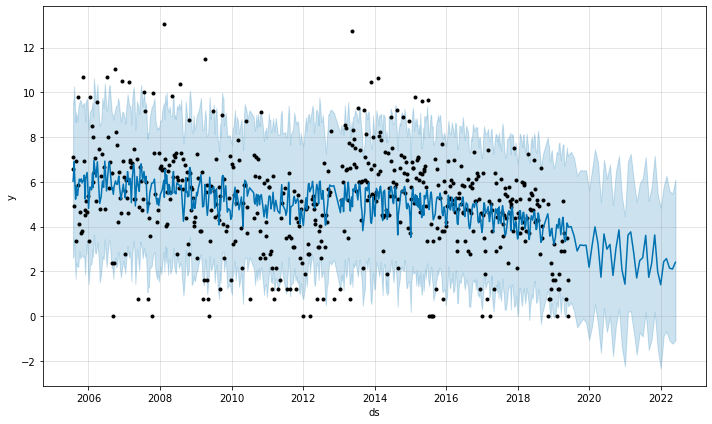

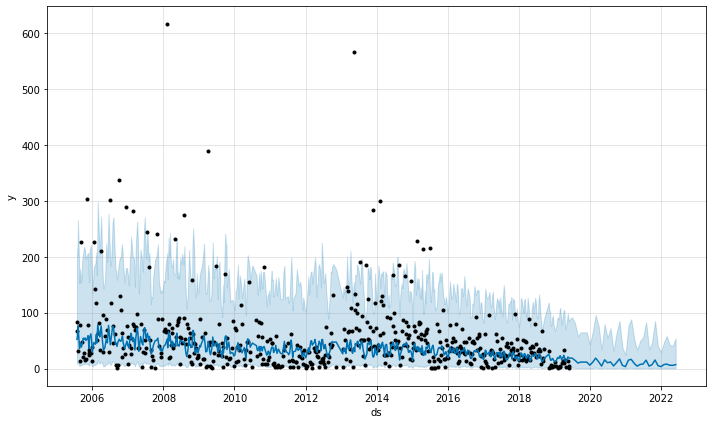

In [11]:

forecast_NO = forecastVariable(c.NO_CC, df, 36)
forecast_NO[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
578,2022-01-31,7.267111,0.251803,48.246486
579,2022-02-28,7.941081,0.430710,51.097560
580,2022-03-31,5.949607,0.293565,42.758050
581,2022-04-30,5.764543,0.243352,37.957036
582,2022-05-31,7.110356,0.345036,44.272432


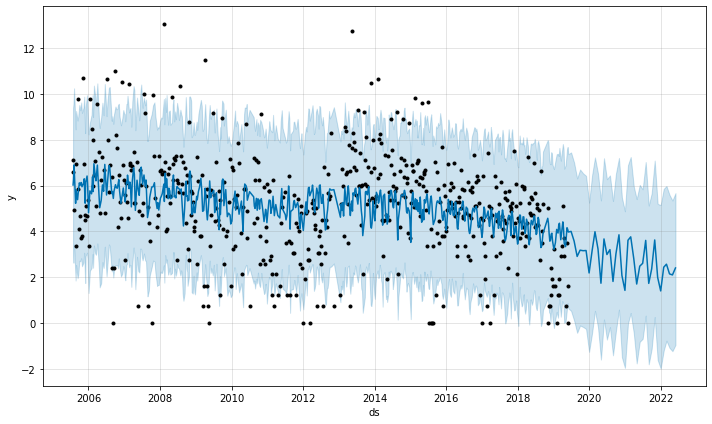

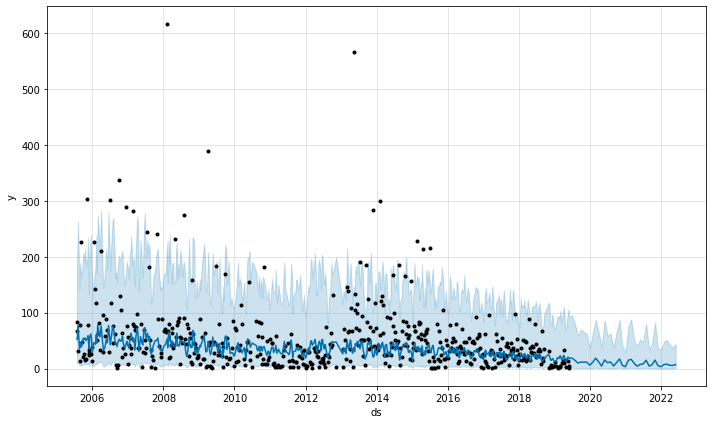

In [12]:
forecast_T_Module= forecastVariable(c.T_MODULE, df, 36)
forecast_T_Module[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

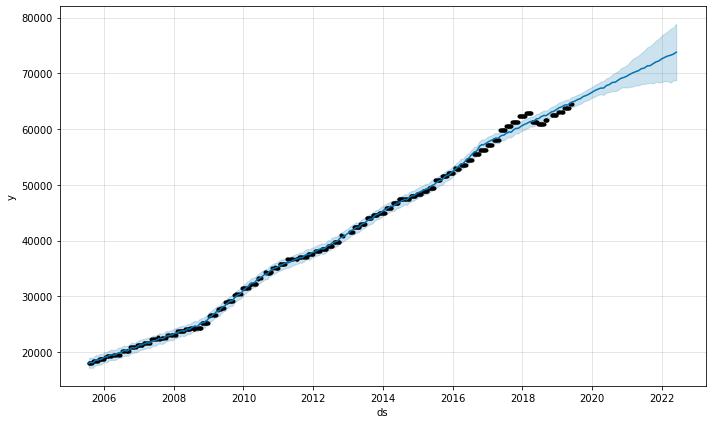

In [31]:
fig_T_Module = m_T_Module.plot(forecast_T_Module)

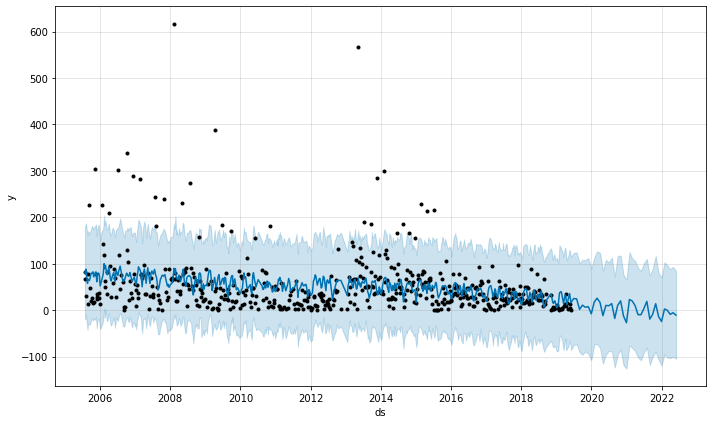

In [32]:
fig_NT = m_NT.plot(forecast_NT)

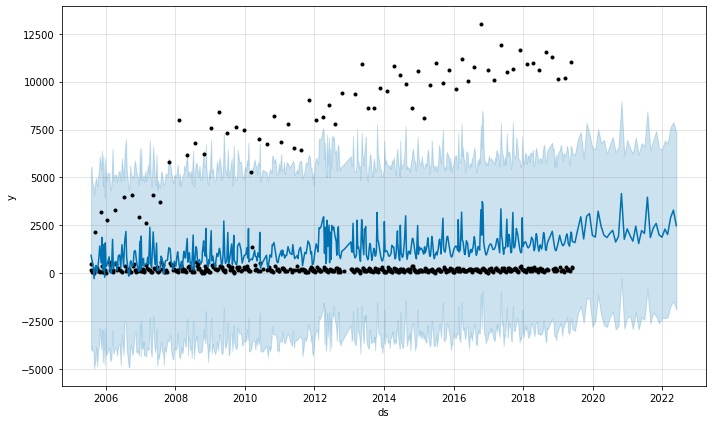

In [33]:
fig_NO = m_NO.plot(forecast_NO)

In [34]:
data = {
    c.NT_CC: forecast_NT['yhat'],
    c.NO_CC: forecast_NO['yhat'],
    c.T_MODULE: forecast_T_Module['yhat']
}

X_Future = pd.DataFrame(data) 
y_pred_rf = rf_regressor.predict(X_Future)
y_pred_index = forecast_NT['ds']

In [35]:
data = {c.MODULE_CC : y_pred_rf.round(2), c.VERSION: y_pred_index}
results = pd.DataFrame(data) 

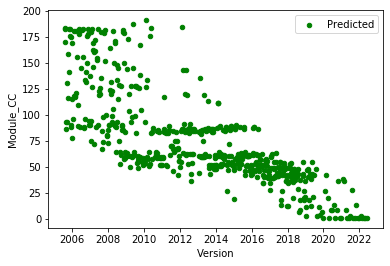

In [36]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.MODULE_CC, c='green', label=c.PREDICTED)

In [39]:
from scipy.stats import boxcox

NT = pd.Series(df[c.NT_CC], df.index)
NT = NT.reset_index()
NT

,Date,NT_CC
0,2005-07-28,83.0
1,2005-08-01,67.0
2,2005-08-07,31.0
3,2005-08-23,78.0
4,2005-08-28,13.0
...,...,...
542,2019-04-21,16.0
543,2019-05-05,2.0
544,2019-05-19,14.0
545,2019-05-26,4.0


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


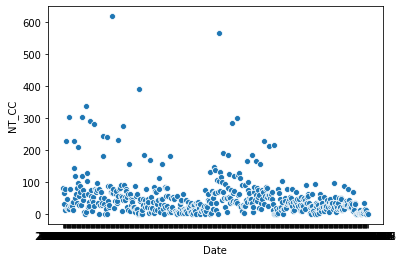

In [50]:
sns.scatterplot(NT[c.DATE], NT[c.NT_CC])

In [45]:
NT['y'], lam = boxcox(NT[c.NT_CC])

In [47]:
NT['y']

0      7.099446
1      6.592217
2      4.936409
3      6.950038
4      3.351243
         ...   
542    3.705331
543    0.743484
544    3.475935
545    1.597503
546    0.000000
Name: y, Length: 547, dtype: float64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


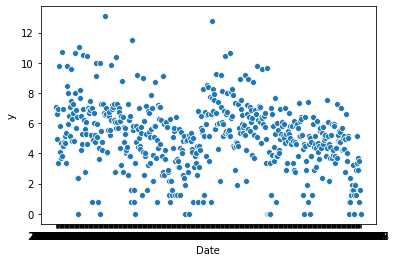

In [48]:
sns.scatterplot(NT[c.DATE], NT['y'])

In [ ]:
m = fbprophet.Prophet()
m.fit(df)